In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import numpy as np
from scipy.optimize import curve_fit
import itertools
import sys
#sys.path.append('/home/wtb2/Documents/EBTEL-2fluid_repo/bin/')
sys.path.append('/Users/willbarnes/Documents/Rice/Research/EBTEL-2fluid_repo/bin/')
import ebtel2fl_plot as ebp
reload(ebp)

<module 'ebtel2fl_plot' from '/Users/willbarnes/Documents/Rice/Research/EBTEL-2fluid_repo/bin/ebtel2fl_plot.pyc'>

#Heating Statistics in EBTEL

Here, we want to determine how many events $\mathcal{N}$ we need to include in our distribution such that our actual power-law index $\alpha_D$ is actually representative of our chosen power-law index $\alpha$. We start be defining a function for the power law distribution that accepts a variable $x$ chosen from a uniform distribution.

In [2]:
def pl_dist(a0,a1,alpha,x):
        return ((a1**(alpha+1) - a0**(alpha+1))*x + a0**(alpha+1))**(1/(alpha+1))

Now let's choose some reasonable limits for our distribution as well as an index. We will use these throughout.

In [3]:
a0 = 0.05
a1 = 0.5
alpha = -2.0

Now choose a vector $x_0$ with 1000 entries all chosen from a uniform distribution and construct our power-law relation.

No file specified. Variable namespace will not be populated.


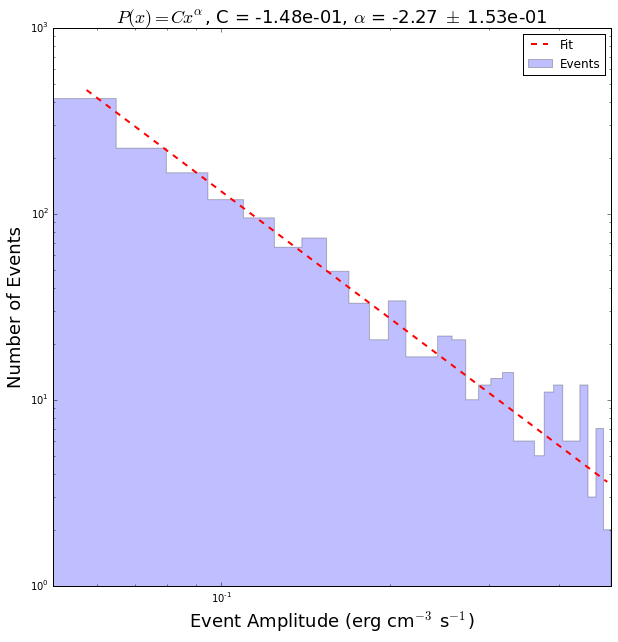

(-2.2669048700976409, 0.15252921870913602)

In [5]:
pl_plotter = ebp.Plotter()
np.random.seed()
x0 = np.random.rand(1500)
pl_plotter.events = pl_dist(a0,a1,alpha,x0)
pl_plotter.plot_event_distribution()

So 1500 events does a decent job of fitting our distribution, but we would like to do better. Let's iterate on the sample size and find a sample that does a better job; an optimal number of events will fit the distribution well within some error $\epsilon$ for our three values of $\alpha=-1.5,-2.0,-2.5$.

In [6]:
def alpha_iterator(pl_instance,a0,a1,alpha,n):
    np.random.seed()
    x0 = np.random.rand(n)
    pl_instance.events = pl_dist(a0,a1,alpha,x0)
    alpha,sigma = pl_instance.plot_event_distribution(no_show=True)
    return alpha,sigma

In [7]:
n = np.logspace(3,7,100)
n = [int(i) for i in n]
pl_indices=[-1.5,-2.0,-2.5]
#alpha-1.5
alpha15_list = []
sigma15_list = []
for i in range(len(n)):
    alpha_temp,sigma_temp = alpha_iterator(pl_plotter,a0,a1,pl_indices[0],n[i])
    alpha15_list.append(np.fabs(alpha_temp)),sigma15_list.append(np.fabs(sigma_temp))
#alpha=2.0
alpha20_list = []
sigma20_list = []
for i in range(len(n)):
    alpha_temp,sigma_temp = alpha_iterator(pl_plotter,a0,a1,pl_indices[1],n[i])
    alpha20_list.append(np.fabs(alpha_temp)),sigma20_list.append(np.fabs(sigma_temp))
#alpha=2.5
alpha25_list = []
sigma25_list = []
for i in range(len(n)):
    alpha_temp,sigma_temp = alpha_iterator(pl_plotter,a0,a1,pl_indices[2],n[i])
    alpha25_list.append(np.fabs(alpha_temp)),sigma25_list.append(np.fabs(sigma_temp))

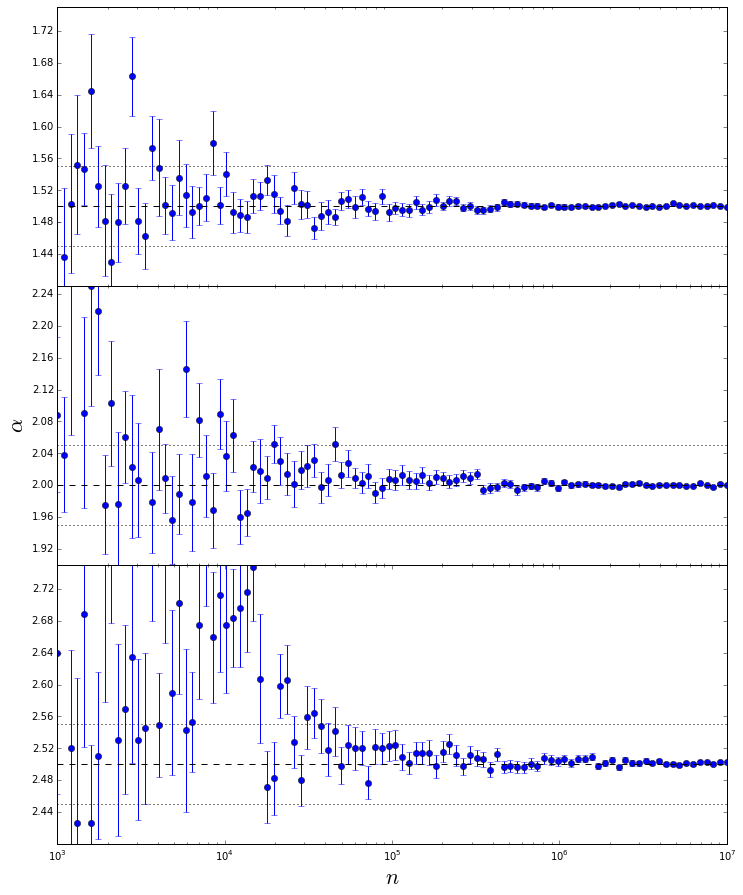

In [8]:
fig,ax = plt.subplots(3,1,figsize=(12,15))
plt.subplots_adjust(hspace=0.0)
alphas = [alpha15_list,alpha20_list,alpha25_list]
sigmas = [sigma15_list,sigma20_list,sigma25_list]
for i in range(len(pl_indices)):
    ax[i].errorbar(n,alphas[i],yerr=sigmas[i],fmt='bo')
    ax[i].plot([n[0],n[-1]],[np.fabs(pl_indices[i]),np.fabs(pl_indices[i])],'--k')
    ax[i].plot([n[0],n[-1]],[np.fabs(pl_indices[i])-0.05,np.fabs(pl_indices[i])-0.05],':k')
    ax[i].plot([n[0],n[-1]],[np.fabs(pl_indices[i])+0.05,np.fabs(pl_indices[i])+0.05],':k')
    ax[i].set_xscale('log')
    ax[i].yaxis.set_major_locator(MaxNLocator(prune='lower'))
    ax[i].set_xlim([n[0],n[-1]])
    ax[i].set_ylim([np.fabs(pl_indices[i])-0.1,np.fabs(pl_indices[i])+0.25])
    if i <(len(pl_indices)-1):
        ax[i].set_xticks([])
ax[1].set_ylabel(r'$\alpha$',fontsize=22)
ax[2].set_xlabel(r'$n$',fontsize=22)
plt.show()

The resulting histograms for $n=10^5$ are shown below.

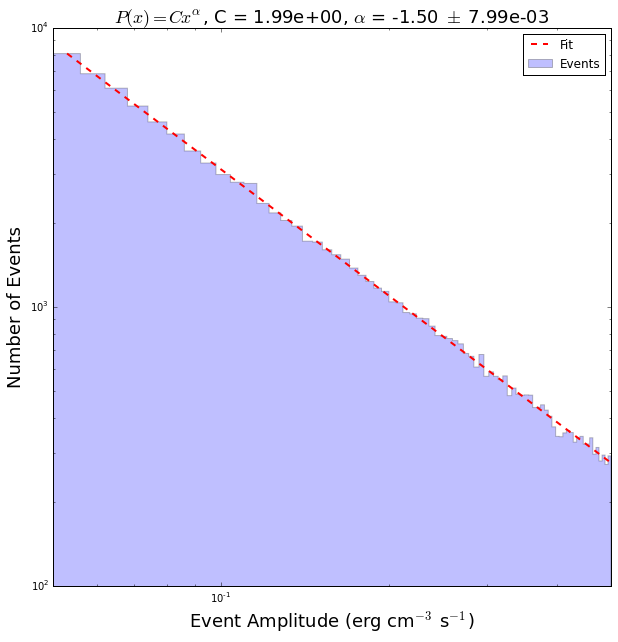

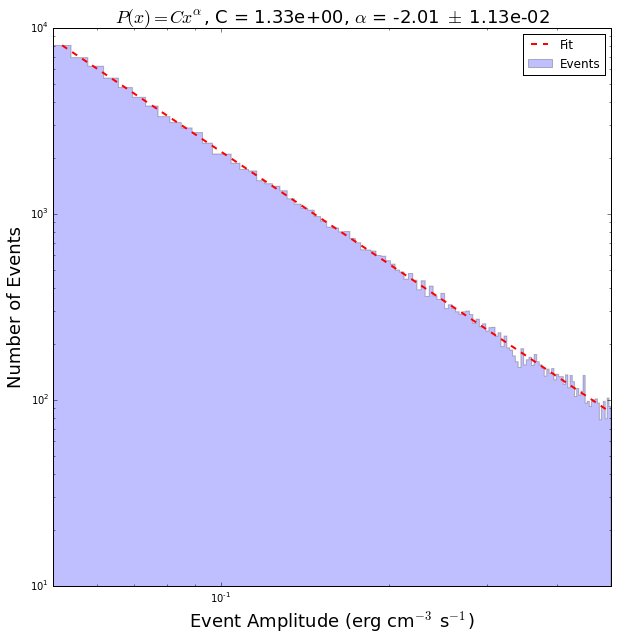

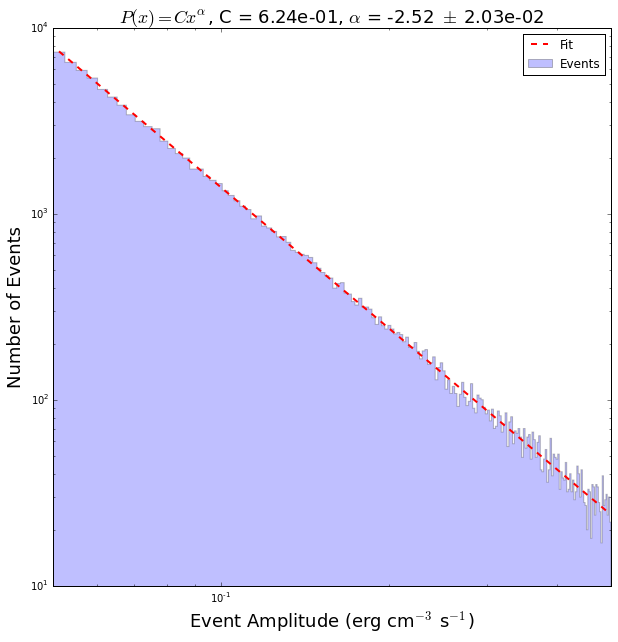

In [21]:
np.random.seed()
x0 = np.random.rand(100000)
for i in range(len(pl_indices)):
    pl_plotter.events = pl_dist(a0,a1,pl_indices[i],x0)
    pl_plotter.plot_event_distribution()

Thus, we can see that after $n\approx10^5$, most significant fluctuations have died down and our power-law index accurately represents our distribution. Thus, for each $\{\alpha,L,T_n\}$ parameter space point, we want to have at least $10^5$ events total when calculating our mean EM curves. Bearing in mind that $N$, the number of events per run, varies with $T_n$, the waiting time, we need to appropriately vary $N_{MC}$, the number of runs per unique configuration file, such that $$\mathcal{N}=N\times N_{MC}\ge10^5.$$ 

We calculate our number of events using the the formula $N=\frac{T_{total}}{t_{pulse}+T_n},$ where $T_{total}$ is the total simulation time and $ t_{pulse} $ is the duration of each heating pulse, assumed to be uniform for the cases we are considering. Now, we can, using our threshold $\mathcal{N}$ value calculated above, find the optimal $N_{MC} $ value for each value of $T_n$. 

In [22]:
def calc_total_events(t_tot,t_pulse,t_n,N_tot):
    N_N = int(np.ceil(t_tot/(t_pulse+t_n)))
    N_MC = int(np.ceil(N_tot/N_N))
    return N_N,N_MC

In [24]:
#define some typical parameters
ttotal = 8.0e+4
tpulse = 1.0e+2
tn = np.arange(250,5250,250)
N_tot = 1.0e+5

In [25]:
#iterate over tn values
nn_list = []
nmc_list = []
for i in range(len(tn)):
    nn_temp,nmc_temp = calc_total_events(ttotal,tpulse,tn[i],N_tot)
    nn_list.append(nn_temp),nmc_list.append(nmc_temp)

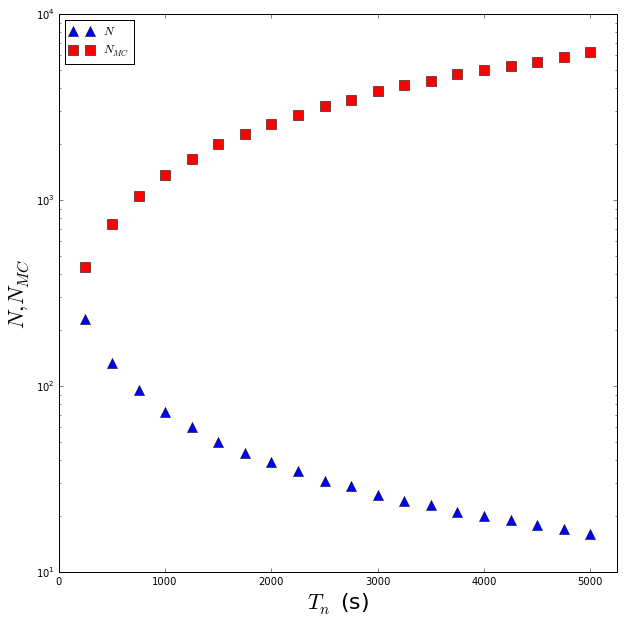

In [26]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.plot(tn,nn_list,'^',markersize=10,label=r'$N$')
ax.plot(tn,nmc_list,'rs',markersize=10,label=r'$N_{MC}$')
ax.set_xlabel(r'$T_n$ (s)',fontsize=22)
ax.set_ylabel(r'$N,N_{MC}$',fontsize=22)
ax.legend(loc=2)
ax.set_yscale('log')
ax.set_xlim([0,tn[-1]+(tn[1]-tn[0])])
plt.show()

Thus, the total number of runs we will need per $\{\alpha,L\}$ parameter space point is:

In [27]:
#sum up the lists
total_runs = sum(nmc_list)
print "The total number of runs we will need to perform per (alpha,L parameter space point is) ",total_runs

The total number of runs we will need to perform per (alpha,L parameter space point is)  66722


Now, let's go and test our resulting heating event statistics and see if they actually obey power-law statistics. We will look at the case of $\alpha=-1.5$, $L=20.0$ Mm, and $T_n=5000$ s. We will load in heating events for every run and then look at the resulting histogram and fit.

In [45]:
#make a data loader function for convenience
def data_loader(species,alpha,loop_length,t_wait,tot_events):
    tot_event_list = []
    file_format = '/data/datadrive2/EBTEL-2fluid_runs/%s_heating_runs/alpha%.1f/data/ebtel2fl_L%.1f_tn%d_tpulse100.0_rka4/ebtel2fl_L%.1f_tn%d_tpulse100.0_rka4_%d_heat_amp.txt'
    for i in range(tot_events):
        temp = np.loadtxt(file_format%(species,alpha,loop_length,t_wait,loop_length,t_wait,i))
        tot_event_list.append(temp)
    #flatten list
    tot_event_list = list(itertools.chain(*tot_event_list))
    return tot_event_list

In [46]:
#load the data
species='electron'
alpha=1.5
loop_length=120.0
t_wait=5000
tot_event_list = data_loader(species,alpha,loop_length,t_wait,np.array(nmc_list)[np.where(tn==t_wait)])

In [47]:
#find the range of our distribution
q0=1.0e+23
q1=1.0e+25
A_cl=1.0e+14
a0 = q0/(loop_length*1.0e+8*A_cl*100.0)
a0 = q1/(loop_length*1.0e+8*A_cl*100.0)
print "The bounds on our distribution are a0 = %.3f ergs cm^-3 s^-1 and a1 = %.3f ergs cm^-3 s^-1"%(a0,a1)

The bounds on our distribution are a0 = 0.083 ergs cm^-3 s^-1 and a1 = 0.500 ergs cm^-3 s^-1


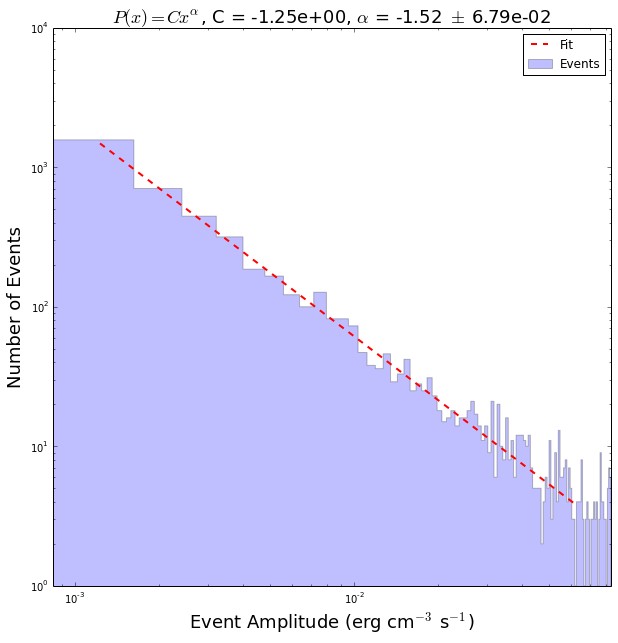

(-1.5193709145174361, 0.06789687816850061)

In [48]:
#plot the distribution
pl_plotter.events=tot_event_list
pl_plotter.plot_event_distribution()

Thus, we can see that even with $n=5\times10^3$ events, our statistics closely match that of the specified power-law index, even for $T_n=5000$ s where we have very few heating events per run. But what about the case of $T_n=250$ s? We've dramatically decreased the number of times we execute these runs. Are the statistics here still acceptable?

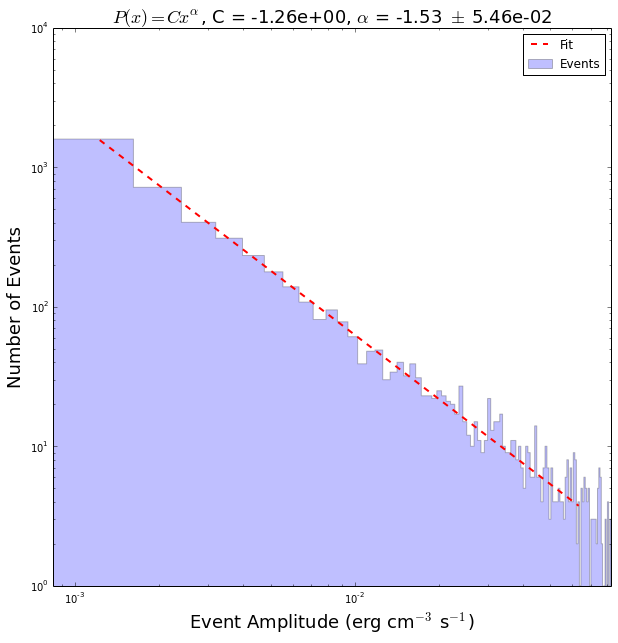

Total number of events: 5038


In [49]:
pl_plotter.events = data_loader(species,alpha,loop_length,250,np.array(nmc_list)[np.where(tn==250)])
pl_plotter.plot_event_distribution()
print "Total number of events: %d"%(len(pl_plotter.events))

Thus, even when using only $\approx20$ runs, we see that we still get very good agreement in the resulting power-law index because our total number of **events**, $\approx5000$, stays the same. 

Now, just to see if any of this has made a difference, let's look back at our old runs, where we chose to run 100 runs for each $\{\alpha,L,T_n\}$ parameter space point. We'll just choose $\alpha=-2.5$ and $L=40.0$ Mm and look at $T_n=250$ s and $T_n=5000$ s.

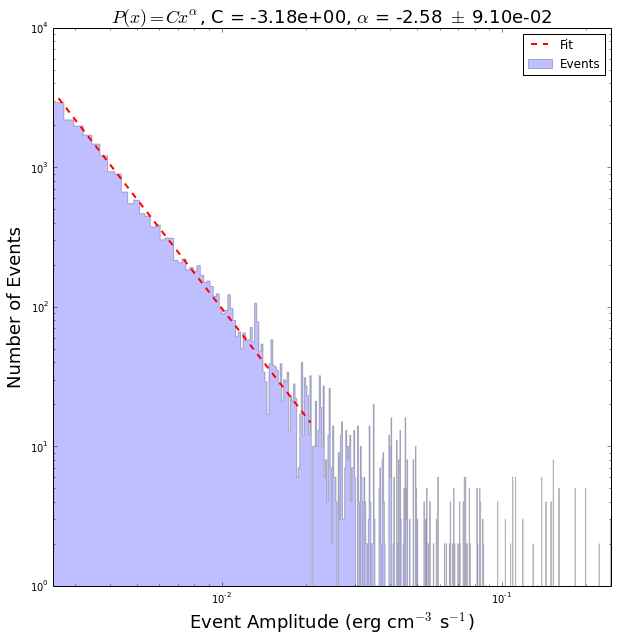

Total number of events: 22900


In [53]:
pl_plotter.events = data_loader(species,2.5,40.0,250,100)
pl_plotter.plot_event_distribution()
print "Total number of events: %d"%(len(pl_plotter.events))

Unsurprisingly, our fit is pretty good though the uncertainty is a little high. The main point is that here we have nearly $2.3\times10^4$ events for $T_n=250$ s. But what if we look at much lower frequency heating, say $T_n=5000$ s?

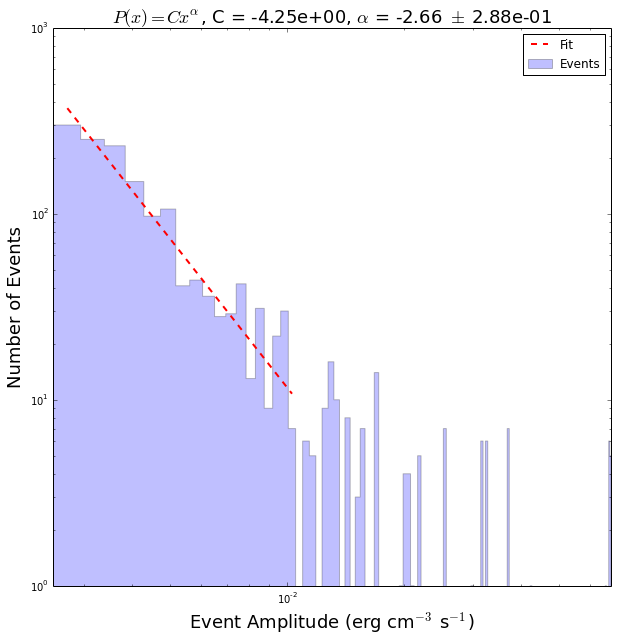

Total number of events: 1600


In [54]:
pl_plotter.events = data_loader(species,2.5,40.0,5000,100)
pl_plotter.plot_event_distribution()
print "Total number of events: %d"%(len(pl_plotter.events))

Our resulting index from our fit is pretty far from the index we used to construct our distribution. Thus, our new Monte Carlo-like method, where we vary the number of MC runs with $T_n$, is much more effective in accurately representing our power-law distribution.

As a final diagnostic, let's plot the resulting power-law index for a particular $\{\alpha,L\}$ as a function of $T_n$, the waiting time. We'll do this first for $\{\alpha=-1.5,L=120.0\}$, where we've used $n=5\times10^3$ total events and then for $\{\alpha=-2.5,L=120.0\}$, where we used a constant $N_{MC}=100$. 

In [55]:
alpha_res_new = []
sigma_res_new = []
for i in range(len(tn)):
    pl_plotter.events = data_loader(species,1.5,120.0,tn[i],nmc_list[i])
    alpha_temp,sigma_temp = pl_plotter.plot_event_distribution(no_show=True)
    alpha_res_new.append(np.fabs(alpha_temp)),sigma_res_new.append(np.fabs(sigma_temp))

In [56]:
alpha_res_old = []
sigma_res_old = []
for i in range(len(tn)):
    pl_plotter.events = data_loader(species,2.5,120.0,tn[i],100)
    alpha_temp,sigma_temp = pl_plotter.plot_event_distribution(no_show=True)
    alpha_res_old.append(np.fabs(alpha_temp)),sigma_res_old.append(np.fabs(sigma_temp))

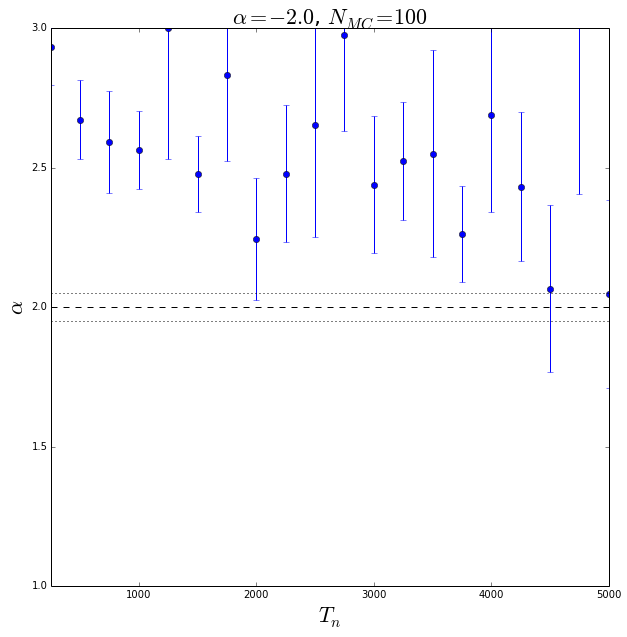

In [57]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.errorbar(tn,alpha_res_old,yerr=sigma_res_old,fmt='bo')
ax.plot([tn[0],tn[-1]],[2.0,2.0],'--k')
ax.plot([tn[0],tn[-1]],[2.05,2.05],':k')
ax.plot([tn[0],tn[-1]],[1.95,1.95],':k')
ax.set_ylabel(r'$\alpha$',fontsize=22)
ax.set_xlabel(r'$T_n$',fontsize=22)
ax.set_title(r'$\alpha=-2.0$, $N_{MC}=100$',fontsize=22)
ax.set_xlim([tn[0],tn[-1]])
ax.set_ylim([1.0,3.0])
plt.show()

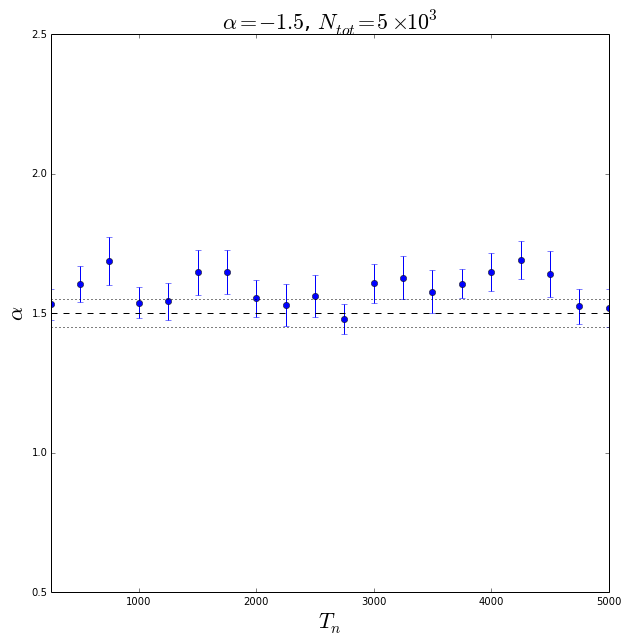

In [58]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.errorbar(tn,alpha_res_new,yerr=sigma_res_new,fmt='bo')
ax.plot([tn[0],tn[-1]],[1.5,1.5],'--k')
ax.plot([tn[0],tn[-1]],[1.55,1.55],':k')
ax.plot([tn[0],tn[-1]],[1.45,1.45],':k')
ax.set_ylabel(r'$\alpha$',fontsize=22)
ax.set_xlabel(r'$T_n$',fontsize=22)
ax.set_title(r'$\alpha=-1.5$, $N_{tot}=5\times10^3$',fontsize=22)
ax.set_xlim([tn[0],tn[-1]])
ax.set_ylim([0.5,2.5])
plt.show()

As we can see, varying $N_{MC}$ while ensuring an adequately large total number of events is essential in ensuring that our actual heating events obey the power-law distribution that we are choosing them from. This is critical when making conclusions based on observables, simulated or otherwise, and inferring heating properties from them.